In [1]:
import imp
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D, InputLayer, LeakyReLU
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import glob 
import csv
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split


C:\Users\sagor\AppData\Local\Temp\ipykernel_17764\2297277722.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
def gen_label(directory):
    label = []
    for dir in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dir)):
            if (dir == 'Cancer'):
                label.append(str(0))
            elif (dir == 'Healthy'):
                label.append(str(1))
    return label

def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [3]:
train_y = gen_label('./Laplacian/train')
train_x = get_path('./Laplacian/train')

In [4]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df)


                                    filename category
0             Cancer/laplacianCancer (1).jpg        0
1             Cancer/laplacianCancer (1).tif        0
2            Cancer/laplacianCancer (10).jpg        0
3           Cancer/laplacianCancer (100).jpg        0
4          Cancer/laplacianCancer (1002).JPG        0
...                                      ...      ...
3664  Healthy/laplacianNot Cancer  (995).jpg        1
3665  Healthy/laplacianNot Cancer  (996).jpg        1
3666  Healthy/laplacianNot Cancer  (997).jpg        1
3667  Healthy/laplacianNot Cancer  (998).jpg        1
3668  Healthy/laplacianNot Cancer  (999).jpg        1

[3669 rows x 2 columns]


In [5]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(2751, 2)
(918, 2)


In [6]:
image_data = ImageDataGenerator(rescale=1./255,
                                validation_split = 0.2,
                                zoom_range=(0.99,0.99))

def preprocessingTrain(path):
    image = image_data.flow_from_directory(directory=path, 
                                           target_size=(224,224), 
                                           batch_size=8, 
                                           seed=123,
                                           subset='training',)
    return image

In [7]:
def preprocessingVal(path):
    
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           )
    return image

In [8]:
def preprocessingTest(path):
    
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           )
    
    return image

In [9]:
path = './Laplacian/train'
train_data = preprocessingTrain(path)

Found 2936 images belonging to 2 classes.


In [10]:
path = './Laplacian/val'
val_data= preprocessingVal(path)

Found 909 images belonging to 2 classes.


In [11]:
path = './Laplacian/test'
test_data = preprocessingTest(path)

Found 909 images belonging to 2 classes.


In [12]:
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

model = keras.Sequential()

model.add(InputLayer(input_shape=(224,224,3)))

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())


model.add(Flatten()) #


# model.add(Dense(2048, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
# model.add(Dense(512, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))
model.add(Dense(2, activation="sigmoid"))


model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205521920 
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4

In [13]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
# Early stopping and model checkpoint
from keras import utils, callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_loss", 
                                        mode="min", 
                                        patience=5, 
                                        restore_best_weights = True)

In [15]:
# model = Sequential()
history = model.fit_generator(train_data,
                              verbose=1,
                              callbacks = [earlystopping],
                              epochs=30,
                              validation_data=(val_data))

c:\Users\sagor\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
367/367 [==============================] - 47s 116ms/step - loss: 0.5127 - accuracy: 0.7738 - val_loss: 0.2693 - val_accuracy: 0.9197
Epoch 2/30
367/367 [==============================] - 42s 115ms/step - loss: 0.2678 - accuracy: 0.8937 - val_loss: 0.1572 - val_accuracy: 0.9516
Epoch 3/30
367/367 [==============================] - 43s 116ms/step - loss: 0.1685 - accuracy: 0.9380 - val_loss: 0.1926 - val_accuracy: 0.9329
Epoch 4/30
367/367 [==============================] - 43s 118ms/step - loss: 0.1049 - accuracy: 0.9619 - val_loss: 0.1151 - val_accuracy: 0.9648
Epoch 5/30
367/367 [==============================] - 60s 164ms/step - loss: 0.1119 - accuracy: 0.9571 - val_loss: 0.0854 - val_accuracy: 0.9802
Epoch 6/30
367/367 [==============================] - 50s 135ms/step - loss: 0.1025 - accuracy: 0.9622 - val_loss: 0.1608 - val_accuracy: 0.9450
Epoch 7/30
367/367 [==============================] - 46s 124ms/step - loss: 0.0823 - accuracy: 0.9724 - val_loss: 0.0681 - val_ac

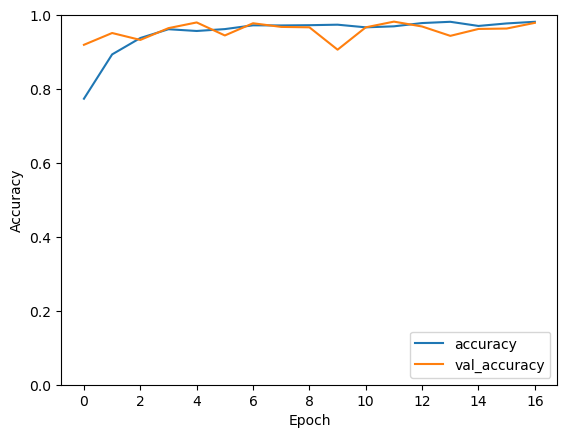

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


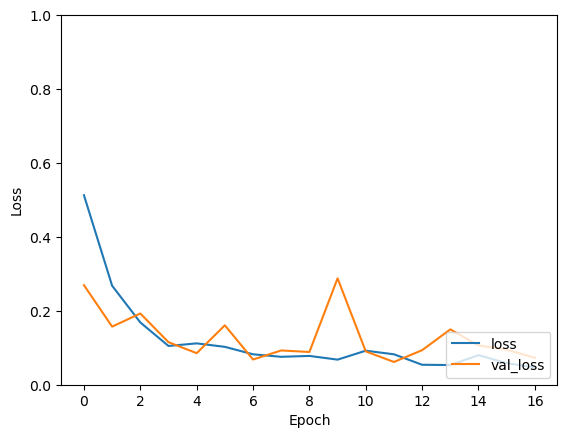

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [18]:
model.pop()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205521920 
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4

In [20]:
feature_list = []
for path in train_df['filename'].to_numpy():
    full_path = './Laplacian/train/'+ path
    x = load_img(full_path,target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)
    feature_list.append(features)
    
# feat_lst = np.reshape(feature_list,(-1,7*7*512))

In [21]:
feat_lst = np.reshape(feature_list,(-1,1024))

In [22]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# features = tarnsfer_model.predict(test_data)
# y  = test_label.astype('int')
y = train_df['category'].to_numpy()
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(feat_lst,
                                                                            y,
                                                                            test_size = 0.20,
                                                                            random_state = 2020)

In [23]:
import csv

# Assuming `features` is a numpy array
import numpy as np

# Define the image names
img_names = [y[i] for i in range(feat_lst.shape[0])]

# Write the features to a CSV file with column names and image names
with open('features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Label'] + list(range(1, feat_lst.shape[1]+1)))
    for i, row in enumerate(feat_lst):
        writer.writerow([img_names[i]] + list(row))

# Read the features from the CSV file
with open('features.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader) # Skip the first row (headers)
    img_names = [row[0] for row in reader] # Extract the image names
    feat_lst = np.array([row[1:] for row in reader]).astype(float) # Extract the features


RANDOM FOREST

In [24]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=4020)

#train classifier
rf_classifier.fit(train_features, train_labels)

# Make predictions on the test data
test_predictions = rf_classifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9891107078039928


Precision for Brain Tumor

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='0')
recall = recall_score(test_labels, test_predictions, pos_label='0')
f1 = f1_score(test_labels, test_predictions, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9965034965034965
Recall:  0.9827586206896551
F1-score:  0.9895833333333334


Precision for Healthy

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='1')
recall = recall_score(test_labels, test_predictions, pos_label='1')
f1 = f1_score(test_labels, test_predictions, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9811320754716981
Recall:  0.9961685823754789
F1-score:  0.9885931558935361


KNN

In [27]:
#Fitting K-NN classifier to the training set  
from sklearn.neighbors import KNeighborsClassifier  
knnClassifier= KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2)  
knnClassifier.fit(train_features, train_labels)  

# Make predictions on the test data
test_predictions_knn = knnClassifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy_knn = accuracy_score(test_labels, test_predictions_knn)

print("Test accuracy: ", test_accuracy_knn)

Test accuracy:  0.9056261343012704


Brain Tumor

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='0')
recall = recall_score(test_labels, test_predictions_knn, pos_label='0')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.871875
Recall:  0.9620689655172414
F1-score:  0.9147540983606558


Healthy

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='1')
recall = recall_score(test_labels, test_predictions_knn, pos_label='1')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9523809523809523
Recall:  0.842911877394636
F1-score:  0.8943089430894309


ADA Boost

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ab_classifier = AdaBoostClassifier(n_estimators=10, random_state=2020)
ab_classifier.fit(train_features, train_labels)
test_predictions_ab = ab_classifier.predict(test_features)
test_accuracy_ab = accuracy_score(test_labels, test_predictions_ab)

print("Test accuracy: ", test_accuracy_ab)

Test accuracy:  0.9655172413793104


Brain Tumor

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='0')
recall = recall_score(test_labels, test_predictions_ab, pos_label='0')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9721254355400697
Recall:  0.9620689655172414
F1-score:  0.9670710571923744


Healthy

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='1')
recall = recall_score(test_labels, test_predictions_ab, pos_label='1')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9583333333333334
Recall:  0.9693486590038314
F1-score:  0.9638095238095239


In [33]:
def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [34]:
test_x = get_path('./Laplacian/test/')

In [35]:
# define function for evaluating model performance on test images
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img

testdf = pd.DataFrame({'filename': test_x})
test_sample = testdf.sample(n = 20, random_state=2020)

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = './Laplacian/test/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'random_forest':
            features = model.predict(img_array)
            result = rf_classifier.predict(features)
        elif name == 'knn':
            features = model.predict(img_array)
            result = knnClassifier.predict(features)
        elif name == 'adaboost':
            features = model.predict(img_array)
            result = ab_classifier.predict(features)
        result = 'Healthy' if float(result) > 0.5 else 'Brain Tumor'
        
        result_lst.append(result)
    return result_lst

In [36]:

rf_result = test_img(model,'random_forest')
ada_result = test_img(model,'adaboost')
knn_result = test_img(model,'knn')

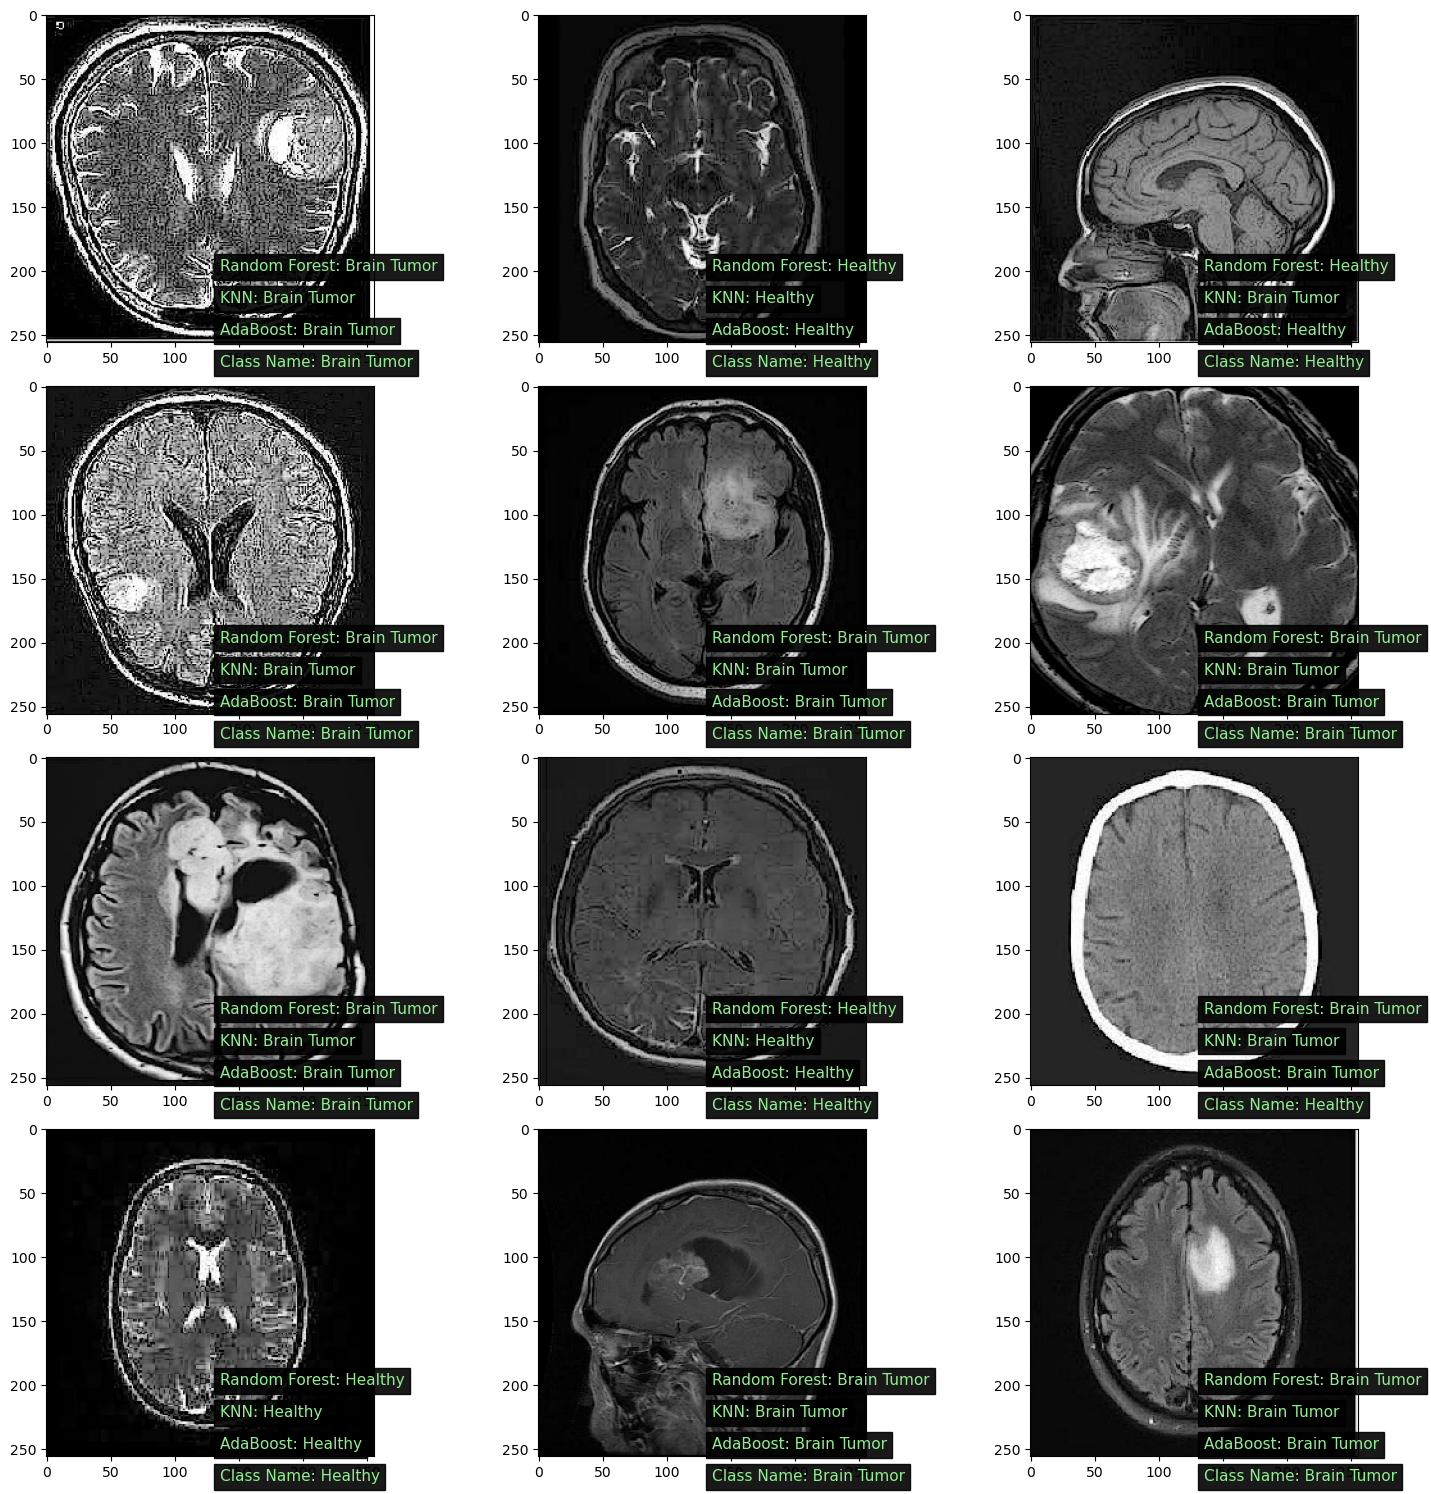

In [37]:
# plotting images with prediction
pred_results  = list(zip(rf_result,knn_result, ada_result))
test_array = test_sample['filename'].to_numpy()

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    rf, knn, ab= pred_results[i]
    img = test_array[i]
    path = './Laplacian/test/' + img
    name = img.split('/')[0]
    if(name == 'Cancer'):
        name = 'Brain Tumor'
    image = load_img(path, target_size=(256,256))
    # plt.text(135, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 200, 'Random Forest: {}'.format(rf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 225, 'KNN: {}'.format(knn), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 250, 'AdaBoost: {}'.format(ab), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 275, 'Class Name: {}'.format(name), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    
    plt.imshow(image)

plt.tight_layout()
plt.show()